## Setup

In [ ]:
!pip install numpy
!pip install pandas
!pip install statsmodels

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Specify project directories in Sherlock
data_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/data/'
results_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/osthoag/wgs-constraint-llm/results/'

# Specify the file paths
annotation_file_path = data_path + 'gencode.v44.basic.annotation.gtf.gz'
constraint_file_path = data_path + 'gnomad.v4.0.constraint_metrics.tsv'
alpha_missense_file_path = data_path + 'AlphaMissense_hg38.tsv.gz'
hmm_predictions_path = results_path + 'HMM_rgc_' + '0.9_over20' + '_chr2' + "_predictions_rgc_wes.tsv.gz"
hmm_predictions_path = results_path + "HMM_rgc_0.9_over20_chr2_predictions_rgc_wes.tsv.gz"

## Load data

In [3]:
# Read the file into a pandas DataFrame
# constraint_df = pd.read_csv(constraint_file_path, sep='\t', usecols=['gene', 'transcript', 'mane_select', 'mis.z_score'])
constraint_df = pd.read_csv(constraint_file_path, sep='\t')

# # Compute the MTR
constraint_df['MTR'] = (constraint_df['mis.obs'] / (constraint_df['mis.obs'] + constraint_df['syn.obs'])) / (constraint_df['mis.exp'] / (constraint_df['mis.exp'] + constraint_df['syn.exp']))

# Drop unnecessary columns
# constraint_df = constraint_df[['gene', 'transcript', 'mane_select', 'mis.z_score', 'lof.z_score', 'MTR']]

constraint_df

,gene,transcript,mane_select,lof_hc_lc.obs,lof_hc_lc.exp,lof_hc_lc.possible,lof_hc_lc.oe,lof_hc_lc.mu,lof_hc_lc.pLI,lof_hc_lc.pNull,...,syn.exp,syn.possible,syn.oe,syn.mu,syn.oe_ci.lower,syn.oe_ci.upper,syn.z_raw,syn.z_score,constraint_flags,MTR
0,A1BG,ENST00000263100,True,45.0,43.008,193.0,1.04630,7.063300e-07,1.572700e-16,0.851710,...,295.680,994.0,1.06870,3.021600e-06,0.974,1.173,-1.181600,-0.644370,[],1.007209
1,A1BG,ENST00000600966,False,24.0,26.243,123.0,0.91451,4.197900e-07,2.496000e-08,0.346550,...,178.730,637.0,0.92876,1.905700e-06,0.818,1.056,0.952380,0.519350,[],1.017737
2,A1BG,NM_130786.4,True,45.0,43.008,193.0,1.04630,7.063300e-07,1.572700e-16,0.851710,...,295.680,994.0,1.06870,3.021600e-06,0.974,1.173,-1.181600,-0.644370,[],1.007209
3,A1CF,ENST00000282641,False,45.0,69.896,352.0,0.64381,9.547100e-07,7.106200e-10,0.002114,...,272.290,1157.0,0.99895,2.007600e-06,0.904,1.104,0.017286,0.009426,[],0.964031
4,A1CF,ENST00000373993,False,43.0,70.294,355.0,0.61172,9.665500e-07,1.009500e-08,0.000938,...,275.790,1173.0,1.00440,2.007600e-06,0.910,1.109,-0.072690,-0.039638,[],0.962264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211267,NaN,ENST00000691540,False,6.0,23.367,101.0,0.25677,5.641100e-07,9.725100e-01,0.000064,...,72.462,273.0,0.97983,1.793000e-06,0.808,1.194,0.171700,0.093629,[],0.910019
211268,NaN,ENST00000691972,False,22.0,38.381,202.0,0.57320,6.304800e-07,1.882800e-04,0.007398,...,139.780,641.0,0.90860,6.413100e-07,0.786,1.053,1.080600,0.589270,[],0.987188
211269,NaN,ENST00000692281,False,46.0,66.376,358.0,0.69302,7.180400e-07,3.574700e-11,0.008375,...,245.080,1115.0,0.84055,8.537600e-07,0.749,0.943,2.496200,1.361200,[],0.980156
211270,NaN,ENST00000692585,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,196.530,703.0,0.95151,3.419600e-06,0.844,1.074,0.679760,0.370680,"[""no_exp_lof""]",1.023435


In [4]:
# Read the GTF file into a pandas DataFrame
gene_df = pd.read_csv(annotation_file_path, sep='\t', comment='#', header=None, 
                      names=['chr', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'], 
                      dtype={'start': int, 'end': int})

# Extract 'gene_id' from attributes
gene_df['gene_id'] = gene_df['attribute'].str.extract(r'gene_id "(.*?)"')

# Extract 'gene_type' from attributes
gene_df['gene_type'] = gene_df['attribute'].str.extract(r'gene_type "(.*?)"')

# Extract 'gene_name' from attributes
gene_df['gene_name'] = gene_df['attribute'].str.extract(r'gene_name "(.*?)"')

# Extract 'transcript_id' from attributes
gene_df['transcript_id'] = gene_df['attribute'].str.extract(r'transcript_id "(.*?)"')

# Extract 'transcript' and 'num' from transcript_id
gene_df[['transcript', 'transcript_num']] = gene_df['transcript_id'].str.split('.', expand=True)

# Extract 'transcript_name' from attributes
gene_df['transcript_name'] = gene_df['attribute'].str.extract(r'transcript_name "(.*?)"')

# Drop the original attribute column
gene_df = gene_df.drop('attribute', axis=1)

# Filter rows for protein-coding regions
gene_df = gene_df[(gene_df['gene_type'] == 'protein_coding') & (gene_df['feature'] == 'CDS')]

gene_df

,chr,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,transcript_id,transcript,transcript_num,transcript_name
60,chr1,HAVANA,CDS,65565,65573,.,+,0,ENSG00000186092.7,protein_coding,OR4F5,ENST00000641515.2,ENST00000641515,2,OR4F5-201
63,chr1,HAVANA,CDS,69037,70005,.,+,0,ENSG00000186092.7,protein_coding,OR4F5,ENST00000641515.2,ENST00000641515,2,OR4F5-201
236,chr1,HAVANA,CDS,450743,451678,.,-,0,ENSG00000284733.2,protein_coding,OR4F29,ENST00000426406.4,ENST00000426406,4,OR4F29-201
304,chr1,HAVANA,CDS,685719,686654,.,-,0,ENSG00000284662.2,protein_coding,OR4F16,ENST00000332831.5,ENST00000332831,5,OR4F16-201
524,chr1,HAVANA,CDS,924432,924948,.,+,0,ENSG00000187634.13,protein_coding,SAMD11,ENST00000616016.5,ENST00000616016,5,SAMD11-209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998488,chrM,ENSEMBL,CDS,10470,10763,.,+,0,ENSG00000212907.2,protein_coding,MT-ND4L,ENST00000361335.1,ENST00000361335,1,MT-ND4L-201
1998495,chrM,ENSEMBL,CDS,10760,12137,.,+,0,ENSG00000198886.2,protein_coding,MT-ND4,ENST00000361381.2,ENST00000361381,2,MT-ND4-201
1998509,chrM,ENSEMBL,CDS,12337,14145,.,+,0,ENSG00000198786.2,protein_coding,MT-ND5,ENST00000361567.2,ENST00000361567,2,MT-ND5-201
1998515,chrM,ENSEMBL,CDS,14149,14673,.,-,0,ENSG00000198695.2,protein_coding,MT-ND6,ENST00000361681.2,ENST00000361681,2,MT-ND6-201


In [5]:
gene_constraint_df = pd.merge(gene_df, constraint_df, left_on=['gene_name', 'transcript'], right_on=['gene', 'transcript'], how='inner')
gene_constraint_df['length'] = abs(gene_constraint_df['end'] - gene_constraint_df['start']) + 1
gene_constraint_df

,chr,source,feature,start,end,score,strand,frame,gene_id,gene_type,...,syn.possible,syn.oe,syn.mu,syn.oe_ci.lower,syn.oe_ci.upper,syn.z_raw,syn.z_score,constraint_flags,MTR,length
0,chr1,HAVANA,CDS,65565,65573,.,+,0,ENSG00000186092.7,protein_coding,...,22.0,0.94816,3.428000e-07,0.536,1.694,0.14086,0.076812,[],0.972060,9
1,chr1,HAVANA,CDS,69037,70005,.,+,0,ENSG00000186092.7,protein_coding,...,22.0,0.94816,3.428000e-07,0.536,1.694,0.14086,0.076812,[],0.972060,969
2,chr1,HAVANA,CDS,924432,924948,.,+,0,ENSG00000187634.13,protein_coding,...,1251.0,1.67150,4.036100e-06,1.563,1.788,-12.77600,-6.966700,"[""outlier_mis"",""outlier_syn""]",0.985311,517
3,chr1,HAVANA,CDS,925922,926013,.,+,2,ENSG00000187634.13,protein_coding,...,1251.0,1.67150,4.036100e-06,1.563,1.788,-12.77600,-6.966700,"[""outlier_mis"",""outlier_syn""]",0.985311,92
4,chr1,HAVANA,CDS,930155,930336,.,+,0,ENSG00000187634.13,protein_coding,...,1251.0,1.67150,4.036100e-06,1.563,1.788,-12.77600,-6.966700,"[""outlier_mis"",""outlier_syn""]",0.985311,182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585694,chr22,HAVANA,CDS,50779055,50779121,.,-,1,ENSG00000079974.19,protein_coding,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[""no_exp_lof"",""no_exp_mis"",""no_exp_syn"",""no_va...",NaN,67
585695,chr22,HAVANA,CDS,50782188,50782294,.,-,0,ENSG00000079974.19,protein_coding,...,103.0,1.03390,4.913600e-07,0.776,1.395,-0.18564,-0.101230,[],0.962344,107
585696,chr22,HAVANA,CDS,50777952,50777981,.,-,1,ENSG00000079974.19,protein_coding,...,103.0,1.03390,4.913600e-07,0.776,1.395,-0.18564,-0.101230,[],0.962344,30
585697,chr22,HAVANA,CDS,50776670,50776749,.,-,1,ENSG00000079974.19,protein_coding,...,103.0,1.03390,4.913600e-07,0.776,1.395,-0.18564,-0.101230,[],0.962344,80


In [6]:
# Get predictions from HMM
predictions_df = pd.read_csv(hmm_predictions_path, sep='\t')
predictions_df

,chr,pos,prob_0,prob_1,observation
0,chr1,925922,9.218631e-34,1.000000,0.0
1,chr1,925923,2.515628e-03,0.997484,1.0
2,chr1,925924,2.518103e-03,0.997482,0.0
3,chr1,925925,4.543584e-05,0.999955,1.0
4,chr1,925926,2.596411e-03,0.997404,1.0
...,...,...,...,...,...
28933587,chr22,50777975,5.029692e-05,0.999950,1.0
28933588,chr22,50777976,7.197833e-05,0.999928,1.0
28933589,chr22,50777977,3.225875e-02,0.967741,1.0
28933590,chr22,50777978,5.462209e-01,0.453779,0.0


## Evaluate relationship between different gnomAD and HMM constraint metrics

1. Aggregate HMM constraint predictions over each gene
2. Compare to an existing constraint metric from gnomAD using a GLM
3. Plot the relationship

In [7]:
# Function to calculate the overlap proportion for a single row
def calculate_overlap(row, chr_pos_dict):
    positions = chr_pos_dict[row['chr']]
    return np.sum((row['start'] <= positions) & (positions <= row['end'])) / row['length']

# Filter for the positions with probability > 0.8 of observing a 0
pos_over_80_dict = {'chr' + str(chromnum):
                    predictions_df[(predictions_df['chr'] == 'chr' + str(chromnum)) & (predictions_df['prob_0'] > 0.8)]['pos'].to_numpy()
                    for chromnum in range(1,23)}


# Apply the function to each row
gene_constraint_df['proportion_over_80'] = gene_constraint_df.apply(lambda row: calculate_overlap(row, pos_over_80_dict), axis=1)

# Filter for the positions with probability > 0.6 of observing a 0
pos_over_60_dict = {'chr' + str(chromnum):
                    predictions_df[(predictions_df['chr'] == 'chr' + str(chromnum)) & (predictions_df['prob_0'] > 0.6)]['pos'].to_numpy()
                    for chromnum in range(1,23)}

# Apply the function to each row
gene_constraint_df['proportion_over_60'] = gene_constraint_df.apply(lambda row: calculate_overlap(row, pos_over_60_dict), axis=1)

# Display the result
gene_constraint_df

,chr,source,feature,start,end,score,strand,frame,gene_id,gene_type,...,syn.mu,syn.oe_ci.lower,syn.oe_ci.upper,syn.z_raw,syn.z_score,constraint_flags,MTR,length,proportion_over_80,proportion_over_60
0,chr1,HAVANA,CDS,65565,65573,.,+,0,ENSG00000186092.7,protein_coding,...,3.428000e-07,0.536,1.694,0.14086,0.076812,[],0.972060,9,0.000000,0.000000
1,chr1,HAVANA,CDS,69037,70005,.,+,0,ENSG00000186092.7,protein_coding,...,3.428000e-07,0.536,1.694,0.14086,0.076812,[],0.972060,969,0.000000,0.000000
2,chr1,HAVANA,CDS,924432,924948,.,+,0,ENSG00000187634.13,protein_coding,...,4.036100e-06,1.563,1.788,-12.77600,-6.966700,"[""outlier_mis"",""outlier_syn""]",0.985311,517,0.000000,0.000000
3,chr1,HAVANA,CDS,925922,926013,.,+,2,ENSG00000187634.13,protein_coding,...,4.036100e-06,1.563,1.788,-12.77600,-6.966700,"[""outlier_mis"",""outlier_syn""]",0.985311,92,0.021739,0.054348
4,chr1,HAVANA,CDS,930155,930336,.,+,0,ENSG00000187634.13,protein_coding,...,4.036100e-06,1.563,1.788,-12.77600,-6.966700,"[""outlier_mis"",""outlier_syn""]",0.985311,182,0.000000,0.038462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585694,chr22,HAVANA,CDS,50779055,50779121,.,-,1,ENSG00000079974.19,protein_coding,...,NaN,NaN,NaN,NaN,NaN,"[""no_exp_lof"",""no_exp_mis"",""no_exp_syn"",""no_va...",NaN,67,0.000000,0.000000
585695,chr22,HAVANA,CDS,50782188,50782294,.,-,0,ENSG00000079974.19,protein_coding,...,4.913600e-07,0.776,1.395,-0.18564,-0.101230,[],0.962344,107,0.000000,0.000000
585696,chr22,HAVANA,CDS,50777952,50777981,.,-,1,ENSG00000079974.19,protein_coding,...,4.913600e-07,0.776,1.395,-0.18564,-0.101230,[],0.962344,30,0.066667,0.333333
585697,chr22,HAVANA,CDS,50776670,50776749,.,-,1,ENSG00000079974.19,protein_coding,...,4.913600e-07,0.776,1.395,-0.18564,-0.101230,[],0.962344,80,0.150000,0.275000


In [8]:
# Drop rows with missing or NaN values
filtered_df = gene_constraint_df.dropna(subset=['mis.z_score', 'proportion_over_80'])

X = filtered_df['mis.z_score']
X = sm.add_constant(X)
y = filtered_df['proportion_over_80']

# Fit the logistic regression model
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     proportion_over_80   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                 1.338e+05
Date:                Wed, 04 Sep 2024   Prob (F-statistic):               0.00
Time:                        09:31:55   Log-Likelihood:             6.8395e+05
No. Observations:              585506   AIC:                        -1.368e+06
Df Residuals:                  585504   BIC:                        -1.368e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0604      0.000    487.974      

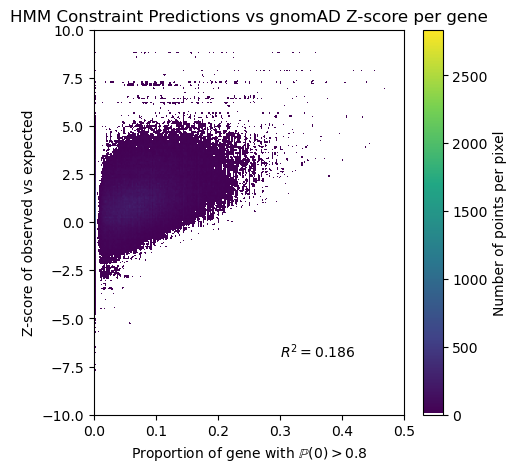

In [9]:
from matplotlib.colors import LinearSegmentedColormap
import mpl_scatter_density

# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='scatter_density')
density = ax.scatter_density(gene_constraint_df['proportion_over_80'], gene_constraint_df['mis.z_score'], cmap=white_viridis)
ax.set_xlabel('Proportion of gene with $\mathbb{P}(0) > 0.8$')
# ax.set_ylabel('Missense Tolerance Ratio z-score')
ax.set_ylabel('Z-score of observed vs expected')
ax.set_xlim([0, 0.5])  # Adjust xlim if needed
ax.set_ylim([-10, 10])   # Adjust ylim if needed
# ax.set_title('Constraint Predictions vs MTR per gene')
ax.set_title('HMM Constraint Predictions vs gnomAD Z-score per gene')
fig.colorbar(density, label='Number of points per pixel')
ax.text(0.3, -7, '$R^2=0.186$', fontsize=10)
plt.show()

In [10]:
# Drop rows with missing or NaN values
filtered_df = gene_constraint_df.dropna(subset=['lof.z_score', 'proportion_over_60'])

X = filtered_df['lof.z_score']
X = sm.add_constant(X)
y = filtered_df['proportion_over_60']

# Fit the logistic regression model
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     proportion_over_60   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                 7.202e+04
Date:                Wed, 04 Sep 2024   Prob (F-statistic):               0.00
Time:                        09:31:58   Log-Likelihood:             4.2415e+05
No. Observations:              584172   AIC:                        -8.483e+05
Df Residuals:                  584170   BIC:                        -8.483e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1277      0.000    564.501      

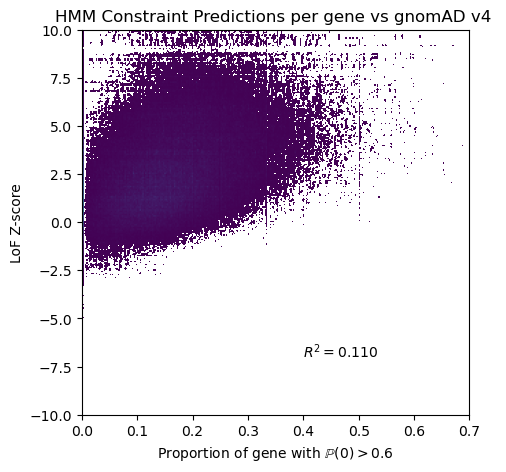

In [11]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='scatter_density')
density = ax.scatter_density(gene_constraint_df['proportion_over_60'], gene_constraint_df['lof.z_score'], cmap=white_viridis)
ax.set_xlabel('Proportion of gene with $\mathbb{P}(0) > 0.6$')
# ax.set_ylabel('Missense Tolerance Ratio z-score')
ax.set_ylabel('LoF Z-score')
ax.set_xlim([0, 0.7])  # Adjust xlim if needed
ax.set_ylim([-10, 10])   # Adjust ylim if needed
# ax.set_title('Constraint Predictions vs MTR per gene')
ax.set_title('HMM Constraint Predictions per gene vs gnomAD v4 ')
# fig.colorbar(density, label='Number of points per pix/el')
ax.text(0.4, -7, '$R^2=0.110$', fontsize=10)
plt.show()

In [12]:
# Drop rows with missing or NaN values
filtered_df = gene_constraint_df.dropna(subset=['mis.z_score', 'proportion_over_60'])

X = filtered_df['mis.z_score']
X = sm.add_constant(X)
y = filtered_df['proportion_over_60']

# Fit the logistic regression model
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     proportion_over_60   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                 1.525e+05
Date:                Wed, 04 Sep 2024   Prob (F-statistic):               0.00
Time:                        09:31:59   Log-Likelihood:             4.5839e+05
No. Observations:              585506   AIC:                        -9.168e+05
Df Residuals:                  585504   BIC:                        -9.168e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1291      0.000    709.185      

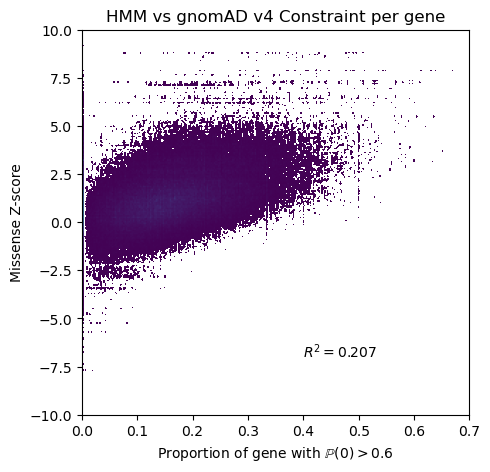

In [13]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='scatter_density')
density = ax.scatter_density(gene_constraint_df['proportion_over_60'], gene_constraint_df['mis.z_score'], cmap=white_viridis)
ax.set_xlabel('Proportion of gene with $\mathbb{P}(0) > 0.6$')
# ax.set_ylabel('Missense Tolerance Ratio z-score')
ax.set_ylabel('Missense Z-score')
ax.set_xlim([0, 0.7])  # Adjust xlim if needed
ax.set_ylim([-10, 10])   # Adjust ylim if needed
# ax.set_title('Constraint Predictions vs MTR per gene')
ax.set_title('HMM vs gnomAD v4 Constraint per gene')
# fig.colorbar(density, label='Number of points per pix/el')
ax.text(0.4, -7, '$R^2=0.207$', fontsize=10)
plt.savefig(results_path + "Figure 1a: HMM vs gnomAD v4 constraint per gene")
plt.show()

In [14]:
# Drop rows with missing or NaN values
filtered_df = gene_constraint_df.dropna(subset=['MTR', 'proportion_over_60'])

X = filtered_df['MTR']
X = sm.add_constant(X)
y = filtered_df['proportion_over_60']

# Fit the logistic regression model
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     proportion_over_60   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                 1.046e+05
Date:                Wed, 04 Sep 2024   Prob (F-statistic):               0.00
Time:                        09:32:01   Log-Likelihood:             4.3881e+05
No. Observations:              585403   AIC:                        -8.776e+05
Df Residuals:                  585401   BIC:                        -8.776e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8950      0.002    399.615      0.0

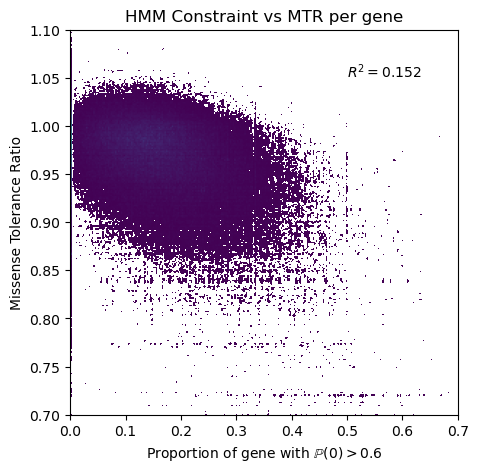

In [15]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='scatter_density')
density = ax.scatter_density(gene_constraint_df['proportion_over_60'], gene_constraint_df['MTR'], cmap=white_viridis)
ax.set_xlabel('Proportion of gene with $\mathbb{P}(0) > 0.6$')
ax.set_ylabel('Missense Tolerance Ratio')
# ax.set_ylabel('Z-score of observed vs expected')
ax.set_xlim([0, 0.7])  # Adjust xlim if needed
ax.set_ylim([0.7, 1.1])   # Adjust ylim if needed
ax.set_title('HMM Constraint vs MTR per gene')
# ax.set_title('HMM Constraint Predictions vs gnomAD Z-score per gene')
# fig.colorbar(density, label='Number of points per pixel')
ax.text(0.5, 1.05, '$R^2=0.152$', fontsize=10)
plt.savefig(results_path + "Figure 1b: HMM vs MTR per gene")
plt.show()